# Mosaic Art

We would like to use images as mosaic pieces to build a bigger image.

Data originally comes from [here](https://www.kaggle.com/thedownhill/art-images-drawings-painting-sculpture-engraving).

In [1]:
import numpy as np
import pandas as pd

from lets_plot import *


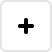
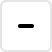
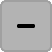
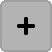
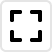
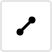
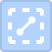
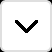
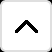
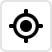
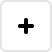
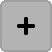
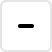
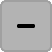
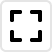
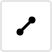
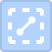
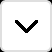
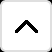
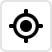

In [2]:
LetsPlot.setup_html()

In [3]:
def get_img_or_none_by_index(i):
    import io
    from os.path import isfile, join
    import requests
    from PIL import Image

    TIMEOUT = 5
    IMAGES_PATH = "images/sculpture"
    IMAGES_URL = "https://github.com/JetBrains/lets-plot-docs/raw/master/source/examples/demo/images/sculpture"

    filepath = join(IMAGES_PATH, "{0}.jpg".format(i))
    if isfile(filepath):
        return Image.open(filepath)
    filepath = join(IMAGES_PATH, "{0}.jpeg".format(i))
    if isfile(filepath):
        return Image.open(filepath)
    r = requests.get("{0}/{1}.jpg".format(IMAGES_URL, i), timeout=TIMEOUT)
    if r.status_code == requests.codes.ok:
        return Image.open(io.BytesIO(r.content))
    r = requests.get("{0}/{1}.jpeg".format(IMAGES_URL, i), timeout=TIMEOUT)
    if r.status_code == requests.codes.ok:
        return Image.open(io.BytesIO(r.content))
    return None

In [4]:
def get_grayscale_img_or_none(img):
    if img is None:
        return None
    if img.mode not in ['RGB', 'L']:
        return None
    return img.convert('L')

In [5]:
WIDTH, HEIGHT = 20, 20
IMAGES_COUNT = 1_732
TARGET_IMAGE = 1_086

In [6]:
data = []
for i in range(IMAGES_COUNT):
    img = get_grayscale_img_or_none(get_img_or_none_by_index(i))
    if img is None:
        continue
    img = img.resize((WIDTH, HEIGHT))
    image_data = np.asarray(img).reshape(WIDTH * HEIGHT)
    image_agg_data = np.array([np.round(image_data.mean()), np.round(image_data.std())])
    data.append(np.concatenate((image_agg_data, image_data), axis=0).astype(int))

In [7]:
df = pd.DataFrame(data)
df = df.rename(columns={0: 'color', 1: 'std'})
df = df.sort_values(by=['color', 'std']).reset_index(drop=True)

In [8]:
ggplot() + \
    geom_bar(aes(x='color', fill='color'), data=df, sampling=sampling_pick(n=256), size=0) + \
    scale_fill_gradient(low='black', high='white') + \
    ggtitle('Gray Color Distribution')

In [9]:
for missing_color in set(range(256)) - set(df.color.unique()):
    df = pd.concat([df, pd.DataFrame.from_records([dict(color=missing_color)])])
df = df.sort_values(by='color').reset_index(drop=True)
df = df.ffill().bfill()

In [10]:
img = get_grayscale_img_or_none(get_img_or_none_by_index(TARGET_IMAGE))
img = img.resize((80, 80))
rows = ()
for row in np.asarray(img):
    cols = ()
    for color in row:
        subimg = df[df.color == color].iloc[0, 2:].to_numpy().reshape(WIDTH, HEIGHT)
        cols = cols + (subimg,)
    rows = rows + (np.hstack(cols),)
image_data = np.vstack(rows)


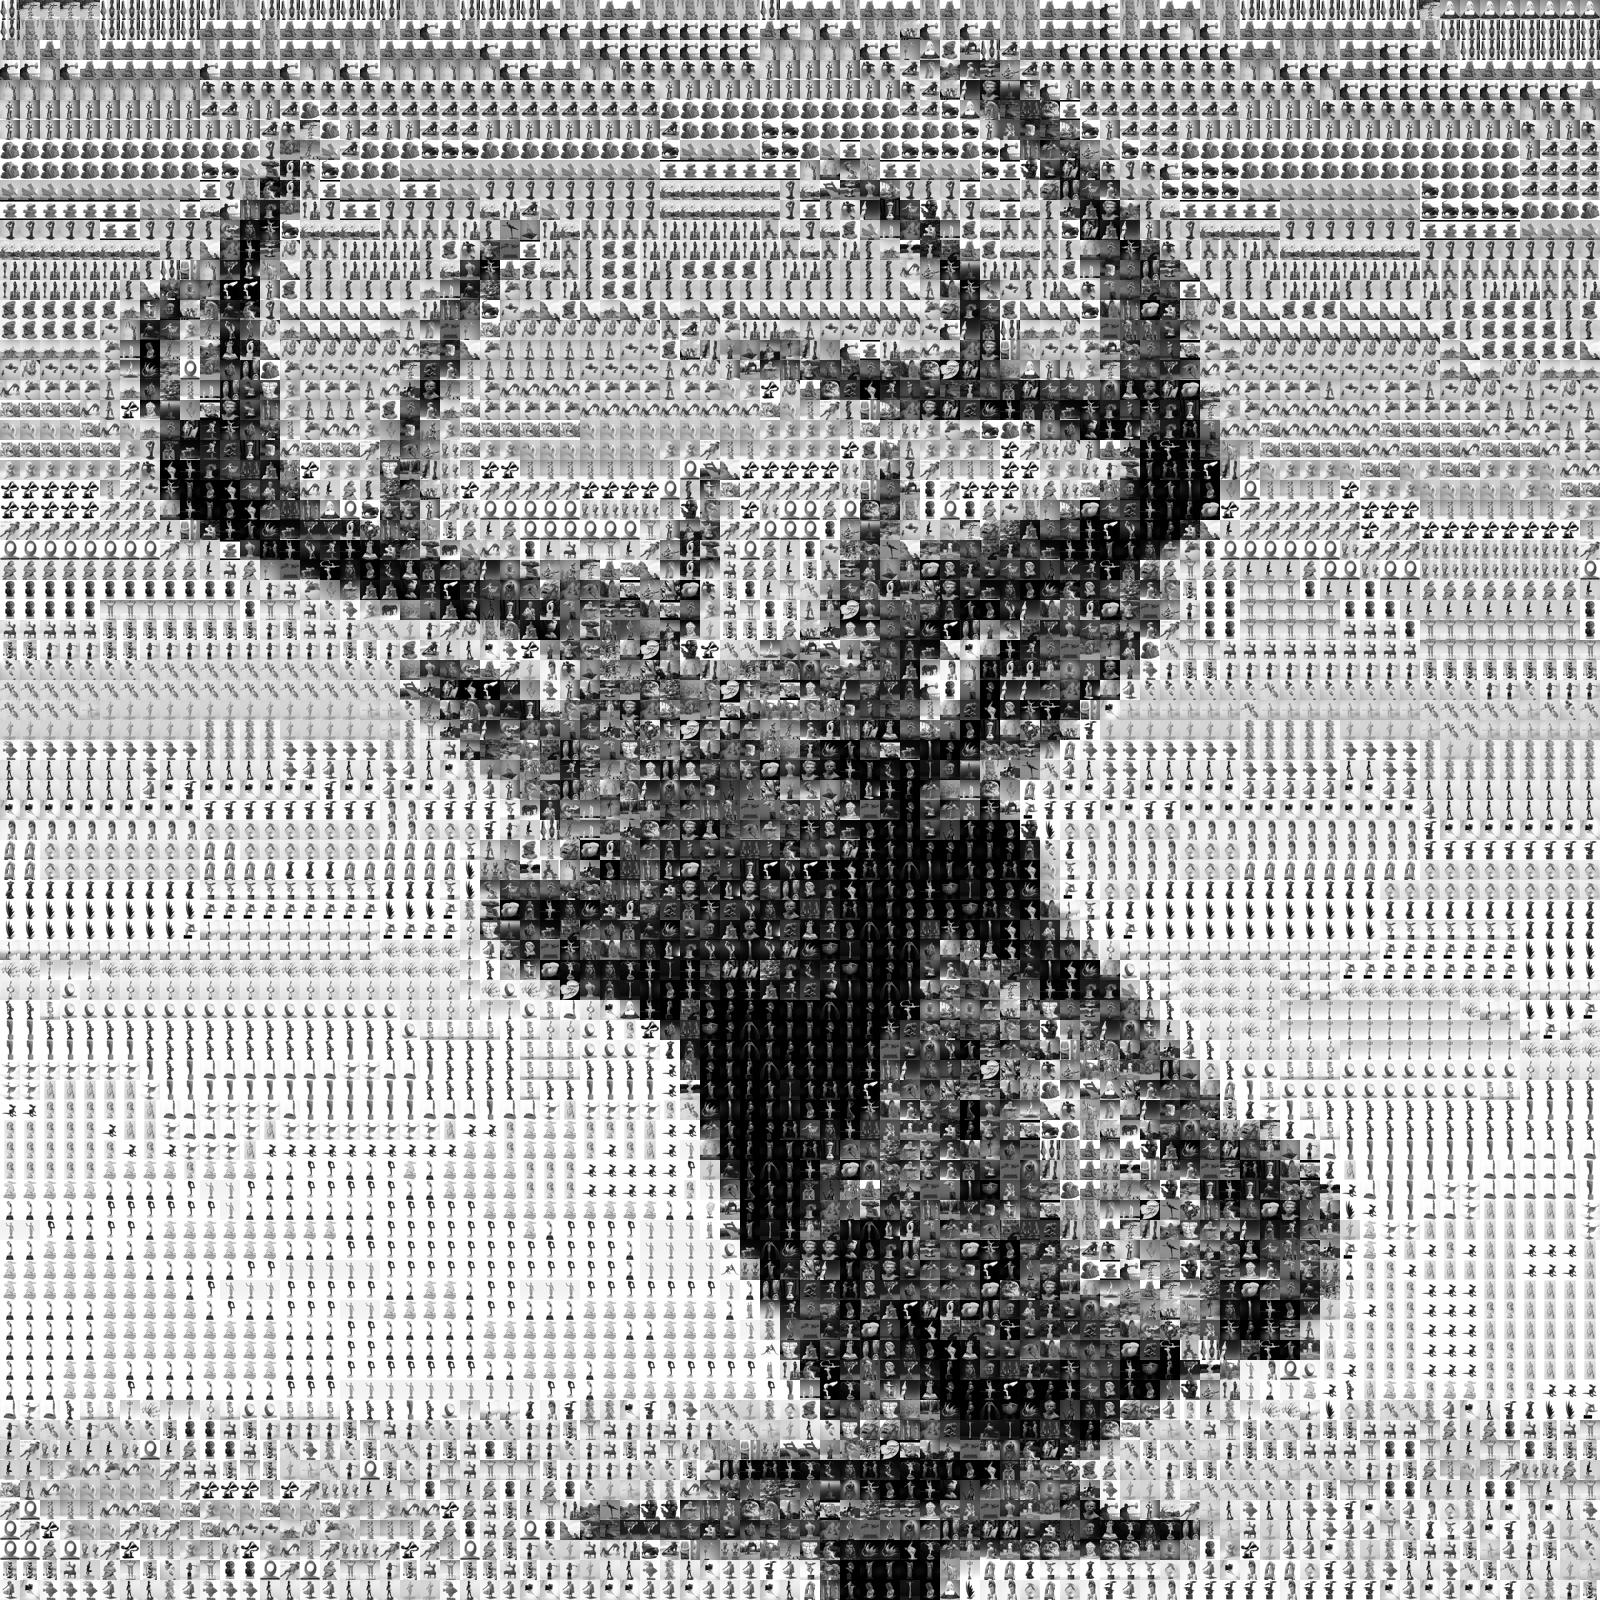

In [11]:
ggplot() + \
    geom_imshow(image_data=image_data) + \
    ggsize(800, 800) + \
    ggtitle('Mosaic Image') + \
    theme_void() + theme(legend_position='none')